# Date: 2013
# Method: 2D 2D BCNN
# Data: Pavia
# Results v.05

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sn

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, Lambda
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import time

from plotly.offline import init_notebook_mode
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

tfd = tfp.distributions
tfpl = tfp.layers



In [ ]:
## VARIABLES

test_ratio = 0.3
test_val_ratio=0.6

train_ratio = 1-test_ratio
#train_val_ratio = 0.8


windowSize = 15  #  25
dimReduction = 80 # dimReduction

drop = 0.4

In [ ]:
# Split Data

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

In [ ]:
# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [ ]:
# Read data
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [ ]:
# Load and reshape data for training
X0, y0 = read_HSI()
#X=X0
#y=y0

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


print(f"Xtrain shape: {Xtrain.shape}\nytrain shape : {ytrain.shape}")
#print(f"Xtest shape: {Xtest.shape}\nytest shape : {ytest.shape}")

X shape: (610, 340, 103)
y shape: (610, 340)
(207400, 103)
Xtrain shape: (29943, 15, 15, 80)
ytrain shape : (29943,)


In [ ]:
# split data for Training and Testing
Xtrain = Xtrain.reshape(-1, windowSize,windowSize, dimReduction)
ytrain = np_utils.to_categorical(ytrain)

#Xvalid, Xtest, yvalid, ytest = splitTrainTestSet(Xtest, ytest, (test_ratio-train_ratio/train_val_ratio)/test_ratio)
Xvalid, Xtest, yvalid, ytest = splitTrainTestSet(Xtest, ytest, test_val_ratio)

Xvalid = Xvalid.reshape(-1, windowSize,windowSize, dimReduction)
yvalid = np_utils.to_categorical(yvalid)

In [ ]:
# Function to define the spike and slab distribution 
# => To be used in prior

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

In [ ]:
# Testing Model_ N01
from tensorflow.keras.optimizers import RMSprop

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
#Testing Model_ N01
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Model_ N02

In [ ]:
# Testing Model_ N02
# Basian deep neural network (BCNN)
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/len(Xtrain)   #3457

# BCNN model
#
model_bayes = Sequential([
    # Statistical 2D conv
    tfpl.Convolution2DReparameterization(input_shape=InputShape, filters=4, kernel_size=2, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,1),
    Conv2D(32, (2,2), activation='relu'),
    MaxPooling2D(2,1),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    # Statistical Dense-
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(9), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    # output-
    tfpl.OneHotCategorical(9)
    
])
model_bayes.summary()



c:\Users\kifah\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.

c:\Users\kifah\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 14, 14, 4)        2568      
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 12, 12, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                        

In [ ]:
# Testing Model_ N02
# Comiple

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.001), #0.005
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [ ]:
# Testing Model_ N02
# Train
hist = model_bayes.fit(Xtrain, 
                       ytrain, 
                       epochs = 20, 
                       batch_size = 512 , 
                       validation_data = (Xvalid, yvalid)    )

Epoch 1/20
59/59 [==============================] - 10s 160ms/step - loss: 0.5209 - accuracy: 0.9700 - val_loss: 0.5123 - val_accuracy: 0.9708
Epoch 2/20
59/59 [==============================] - 9s 148ms/step - loss: 0.5065 - accuracy: 0.9734 - val_loss: 0.4965 - val_accuracy: 0.9817
Epoch 3/20
59/59 [==============================] - 8s 139ms/step - loss: 0.4985 - accuracy: 0.9759 - val_loss: 0.4963 - val_accuracy: 0.9801
Epoch 4/20
59/59 [==============================] - 8s 141ms/step - loss: 0.4864 - accuracy: 0.9801 - val_loss: 0.4850 - val_accuracy: 0.9842
Epoch 5/20
59/59 [==============================] - 8s 140ms/step - loss: 0.4823 - accuracy: 0.9820 - val_loss: 0.4817 - val_accuracy: 0.9821
Epoch 6/20
59/59 [==============================] - 8s 139ms/step - loss: 0.4719 - accuracy: 0.9841 - val_loss: 0.4670 - val_accuracy: 0.9875
Epoch 7/20
59/59 [==============================] - 8s 143ms/step - loss: 0.4653 - accuracy: 0.9857 - val_loss: 0.4690 - val_accuracy: 0.9906
Epoch

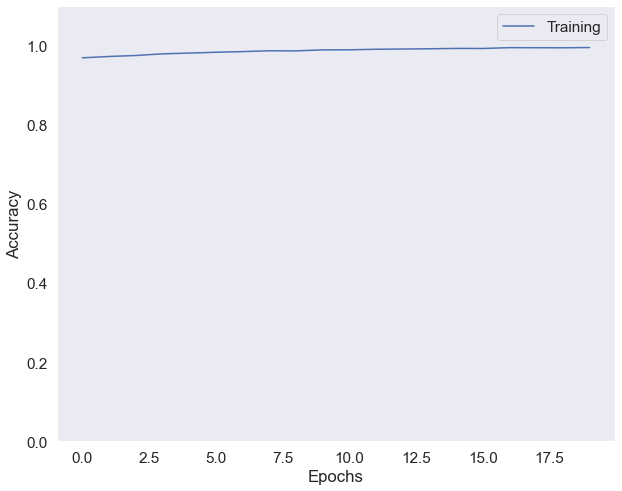

In [ ]:
# Plot accuracy
plt.figure(figsize=(10,8))
plt.ylim(0,1.1)
plt.grid()
plt.plot(hist.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

In [ ]:
# 9 classes
names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']

241/241 [==============================] - 1s 5ms/step


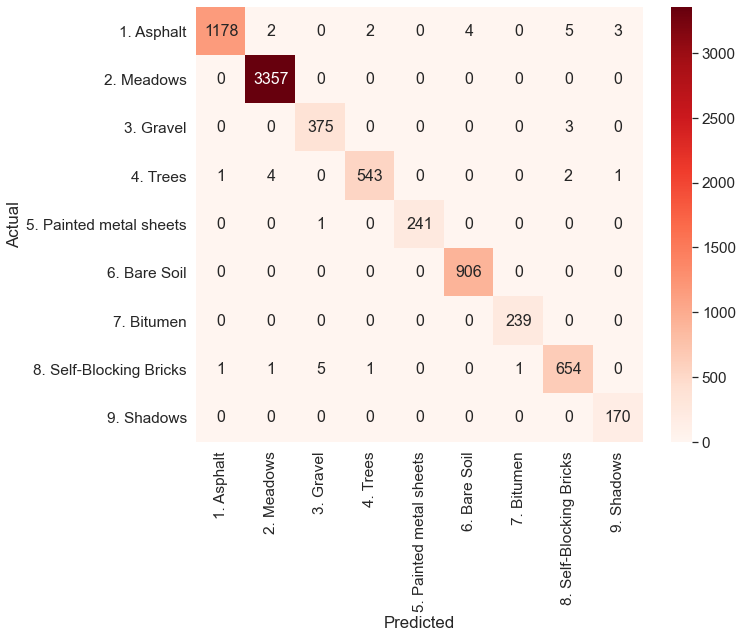

In [ ]:
# confusion_matrix
Y_pred = model_bayes.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)

confusion = confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)


In [ ]:
# average_acc
from operator import itemgetter
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num((list_diag/ list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
# average_acc

each_acc, aa = AA_andEachClassAccuracy(confusion)
print("accuracy for each:")
print (each_acc)

print("OA accuracy:")
print(aa)

accuracy for each:
[0.98659966 1.         0.99206349 0.98548094 0.99586777 1.
 1.         0.98642534 1.        ]
OA accuracy:
0.9940485787505923


In [ ]:
# classification_report
print(classification_report(ytest, y_pred, target_names = names, digits = 3))

                         precision    recall  f1-score   support

             1. Asphalt      0.998     0.987     0.992      1194
             2. Meadows      0.998     1.000     0.999      3357
              3. Gravel      0.984     0.992     0.988       378
               4. Trees      0.995     0.985     0.990       551
5. Painted metal sheets      1.000     0.996     0.998       242
           6. Bare Soil      0.996     1.000     0.998       906
             7. Bitumen      0.996     1.000     0.998       239
8. Self-Blocking Bricks      0.985     0.986     0.986       663
             9. Shadows      0.977     1.000     0.988       170

               accuracy                          0.995      7700
              macro avg      0.992     0.994     0.993      7700
           weighted avg      0.995     0.995     0.995      7700



In [ ]:
# Calculation  the predicted image
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [ ]:
# Calculation  the predicted image
PATCH_SIZE = windowSize
#X2_shifted, y0

#X,pca,ratio = applyPCA(X0,numComponents=40)

X = padWithZeros(X2_shifted, PATCH_SIZE//2) # PATCH_SIZE=15,  PATCH_SIZE//2=7
height = y0.shape[0]
width = y0.shape[1]


In [ ]:
# the predicted image

outputs = np.zeros((height,width),dtype="float16")
outputs2 = np.zeros((height,width),dtype="float16")
for i in range(0,height,1):
    for j in range(0,width,1):            
        target = int(y0[i,j])
        if target == 0 :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction2 = (model_bayes.predict(X_test_image))
            prediction2 = np.argmax(prediction2, axis=1)
            outputs2[i][j] = prediction2+1
            print(i); print(j)
            #print(outputs2[i][j])
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model_bayes.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
            outputs2[i][j] = prediction+1
            #print("target=1")
            #print(outputs2[i][j])


In [ ]:

import spectral
ground_truth = spectral.imshow(classes = y0,figsize =(10,8),cmap='nipy_spectral'); plt.colorbar()


predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7),cmap='nipy_spectral')
predict_image2 = spectral.imshow(classes = outputs2.astype(int),figsize =(7,7))

#spectral.save_rgb("predictions.png", outputs.astype(int), colors=spectral.spy_colors)
#spectral.save_rgb("predictions2.png", outputs2.astype(int), colors=spectral.spy_colors)

